# Seminar plan

In this notebook we will:

    1. Implement variational optimization:
        - and find even more pitfalls in "theoretically nicely working" methods;
    2. Implement Gumbel Softmax Trick:
        - and train classifier with it.

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
from torch import nn
import pyro
from pyro import distributions as distrs
import seaborn as sns
import numpy.testing as np_testing

from IPython.display import clear_output

sns.set(font_scale=1.5, rc={'figure.figsize':(11.7, 8.27)})

In [2]:
def sample(d: distrs.Distribution, num: int):
    """
    Sample from d samples with Pyro reparameterization capabilities
    """
    res = pyro.sample("dist", d.expand([num]))
    return res

## 1. Optimization of the synthetic function

We are going to optimize this function:

$$ f(x) = \log ((x - 0.35)^2 + 1) - 0.15 \exp(-10 |x - 0.8|)$$

In [3]:
def fun_from_lecture(x):
    """
    Some unknown synthetic function from the lecture
    """
    return (torch.log1p((x - 0.35) ** 2) - 0.15 * torch.exp(-10 * torch.abs(x - 0.8))).detach()

In [4]:
x = torch.linspace(0., 1., 1000)

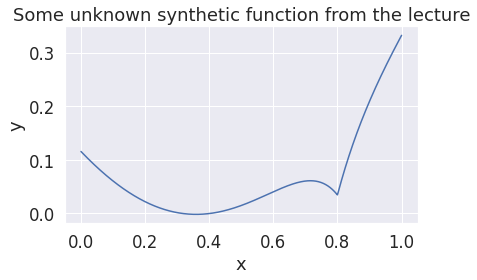

In [5]:
plt.figure()
plt.plot(x, fun_from_lecture(x))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Some unknown synthetic function from the lecture')
plt.tight_layout()
plt.show()

In [6]:
def get_parameters_for_normal_dsitribution(mu=0., sigma=1., dim=2):
    """
    Creates trainable parameters for the normal distribution
    """
    train_mu = torch.Tensor(dim * [mu]).float().requires_grad_(True)
    train_sigma = (torch.eye(dim) * sigma).float().requires_grad_(True)
    return train_mu, train_sigma

def create_normal_distr(mu, sigma):
    """
    Given mu and sigma returns MultivariateNormal
    """
    return distrs.MultivariateNormal(mu, sigma)

In [7]:
mu, sigma = get_parameters_for_normal_dsitribution(dim=1)

## 1.1 Estimation of the variational bound

$\DeclareMathOperator*{\myE}{\mathop{\mathbb{E}}}$

##### In theory:

$$J(\psi) = \myE_{\theta \sim P(\cdot \,\mid\, \psi)} f(\theta) \to \min_\psi$$


##### In practice:

$$J(\psi) = \frac{1}{N} \sum\limits_{\theta \sim P(\cdot \,\mid\, \psi)} f(\theta) \to \min_\psi,$$

where the choice of $N$ depends only on your resources and availability of $f(\cdot)$.

In [8]:
from typing import Callable, List
def estimage_variational_bound(fun: Callable, create_dist: Callable, parameters: List[torch.Tensor], num_samples=5):
    """
    fun: function for which you want to estimate variational bound 
    create_dist: function that takes list of parameters and returns pyro distribution
    parameters: parameters of the distribution, that you will pass to create dist function
    num_samples: number of samples used to evaluate var bound
    
    var_bound: 
    """
    dist = create_dist(*parameters)
    samples = sample(dist, num_samples).detach()
    var_bound = fun(samples).mean()
    return var_bound

In [9]:
mu = torch.tensor([0.])
sigma = torch.tensor([[1.]])
num_samples = 100
res = [estimage_variational_bound(
    fun=fun_from_lecture,
    create_dist=create_normal_distr,
    parameters=[mu, sigma],
    num_samples=num_samples
) for _ in range(100)]

assert 0.56 - 0.06 * 7 < torch.stack(res).mean() < 0.56 + 0.06 * 7, "It should be impossible..."
assert 0.06 - 0.005 * 7 < torch.stack(res).std() < 0.06 + 0.005 * 7, "That's also should be impossible, it's 7 sigma!"

mu = torch.tensor([0.8])
sigma = torch.tensor([[0.01]])
num_samples = 100000000
res = estimage_variational_bound(
    fun=fun_from_lecture,
    create_dist=create_normal_distr,
    parameters=[mu, sigma],
    num_samples=num_samples
)
np_testing.assert_approx_equal(actual=res.item(), desired=0.1114, significant=2)


mu = torch.tensor([0.3])
sigma = torch.tensor([[0.02]])
num_samples = 100000000
res = estimage_variational_bound(
    fun=fun_from_lecture,
    create_dist=create_normal_distr,
    parameters=[mu, sigma],
    num_samples=num_samples
)
np_testing.assert_approx_equal(actual=res.item(), desired=0.01907, significant=2)

### Let's plot some variational bounds!

In [10]:
from collections import defaultdict
num_samples = 1000

sigma_plots = defaultdict(list)
mus = torch.linspace(0., 1., 100).view(-1, 1)

for sigma in tqdm(torch.tensor([0.01, 0.05, 0.1, 0.2]).view(-1, 1, 1).pow(2)):
    for mu in mus:
        sigma_plots[sigma.sqrt().item()].append(
            estimage_variational_bound(
                fun=fun_from_lecture,
                create_dist=create_normal_distr,
                parameters=[mu, sigma],
                num_samples=num_samples
            )
        )
for sigma in sigma_plots:
    sigma_plots[sigma] = torch.stack(sigma_plots[sigma])

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:01<00:03,  1.23s/it]

 50%|█████     | 2/4 [00:03<00:03,  1.58s/it]

 75%|███████▌  | 3/4 [00:05<00:01,  1.70s/it]

100%|██████████| 4/4 [00:07<00:00,  1.83s/it]

100%|██████████| 4/4 [00:07<00:00,  1.93s/it]

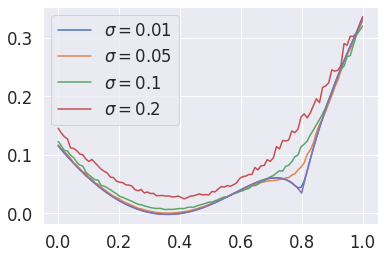

In [11]:
for sigma in sigma_plots:
    plt.plot(mus, sigma_plots[sigma], label=r"$\sigma={:.4}$".format(sigma))
plt.legend()
plt.plot(x, fun_from_lecture(x))

![Moar samples](https://raw.githubusercontent.com/SchattenGenie/pic-storage/master/moar_samples.jpg)

## 1.2 Now we are going to estimate the gradient of the variational bound

In theory:

$$\nabla_\psi J(\psi) = \myE_{\theta \sim P(\cdot\mid\psi)} f(\theta)\; \nabla_\psi \log P(\theta\mid\psi)$$

In practice:

$$\nabla_\psi J(\psi) = \frac{1}{N} \sum\limits_{\theta \sim P(\cdot \,\mid\, \psi)}  f(\theta)\; \nabla_\psi \log P(\theta\mid\psi)$$



In [16]:
from torch import autograd

def estimage_variational_grad(fun: Callable, create_dist: Callable, parameters: List[torch.Tensor], num_samples=5):
    """
    fun: function for which you want to estimate variational bound 
    create_dist: function that takes list of parameters and returns pyro distribution
    parameters: parameters of the distribution, that you will pass to create dist function
    num_samples: number of samples used to evaluate var bound
    
    grads: list of torch tensors with the same shape as 
    """
    parameters = [p.requires_grad_(True) for p in parameters]
    dist = create_dist(*parameters)
    samples = sample(dist, num_samples).detach()
    fun_val = fun(samples)
    grads = autograd.grad((fun_val.view(-1) * dist.log_prob(samples)).mean(), parameters)
    return grads

In [17]:
num_samples = 100000000

mu = torch.tensor([0.8])
sigma = torch.tensor([[0.01]])
grad = estimage_variational_grad(
    fun=fun_from_lecture,
    create_dist=create_normal_distr,
    parameters=[mu, sigma],
    num_samples=num_samples
)
np_testing.assert_approx_equal(actual=grad[0].item(), desired=0.73411, significant=2)
np_testing.assert_approx_equal(actual=grad[1].item(), desired=2.568, significant=2)


mu = torch.tensor([0.2])
sigma = torch.tensor([[0.04]])
grad = estimage_variational_grad(
    fun=fun_from_lecture,
    create_dist=create_normal_distr,
    parameters=[mu, sigma],
    num_samples=num_samples
)
np_testing.assert_approx_equal(actual=grad[0].item(), desired=-0.28668, significant=2)
np_testing.assert_approx_equal(actual=grad[1].item(), desired=0.75752, significant=2)

## 1.3 Optimization!

Do not look here, just some data for some plots...

In [18]:
num_samples = 100000

mu_grid = np.linspace(0, 1, num=21)
sigma_grid = np.linspace(0, 0.5, num=21)[1:]

Mu, Sigma = np.meshgrid(mu_grid, sigma_grid,)

dJ_dmu = np.zeros(shape=(mu_grid.shape[0], sigma_grid.shape[0]))
dJ_dsigma = np.zeros(shape=(mu_grid.shape[0], sigma_grid.shape[0]))

for i, mu in tqdm(enumerate(mu_grid)):
    for j, sigma in enumerate(sigma_grid):
        grads = estimage_variational_grad(
            fun=fun_from_lecture,
            create_dist=create_normal_distr,
            parameters=[torch.tensor(mu).view(1), torch.tensor(sigma).pow(2).view(1, 1)],
            num_samples=num_samples
        )
        dJ_dmu[i, j], dJ_dsigma[i, j] = grads[0].item(), grads[1].item()

0it [00:00, ?it/s]

1it [00:00,  2.26it/s]

2it [00:00,  2.23it/s]

3it [00:01,  2.27it/s]

4it [00:01,  2.29it/s]

5it [00:02,  2.27it/s]

6it [00:02,  2.30it/s]

7it [00:03,  2.31it/s]

8it [00:03,  2.28it/s]

9it [00:03,  2.29it/s]

10it [00:04,  2.26it/s]

11it [00:04,  2.29it/s]

12it [00:05,  2.32it/s]

13it [00:05,  2.29it/s]

14it [00:06,  2.32it/s]

15it [00:06,  2.34it/s]

16it [00:06,  2.34it/s]

17it [00:07,  2.12it/s]

18it [00:07,  2.18it/s]

19it [00:08,  2.18it/s]

20it [00:08,  2.22it/s]

21it [00:09,  2.22it/s]

21it [00:09,  2.26it/s]

In [19]:
def plot_optimization_path():
    fig = plt.figure(figsize=(9, 9), constrained_layout=True, dpi=100)
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 2])

    ax1 = fig.add_subplot(gs[0, 0])
    for sigma in sigma_plots:
        plt.plot(mus, sigma_plots[sigma], label=r"$\sigma={:.4}$".format(sigma))

    fig.add_subplot(gs[1, 0], sharex=ax1)

    plt.vlines([0.35, 0.8], ymin=0, ymax=sigma_grid[-1], lw=2, linestyles='--', color=plt.cm.tab10(1), alpha=0.75)
    plt.quiver(mu_grid, sigma_grid, -dJ_dmu.T, -dJ_dsigma.T, angles='xy')

    plt.ylim([0, sigma_grid[-1]])
    plt.xlim([mu_grid[0], mu_grid[-1]])

    plt.xlabel('$\\mu$');
    plt.ylabel('$\\sigma$');

### Optimization!

1. Initialize parameters $\mu$ and $\sigma$

In [20]:
mu, sigma = get_parameters_for_normal_dsitribution(mu=0.95, sigma=0.5, dim=1)

2. Get your favorite optimizer ready

In [21]:
opt = torch.optim.SGD([mu, sigma], lr=1e-2)

3. Optimization start!

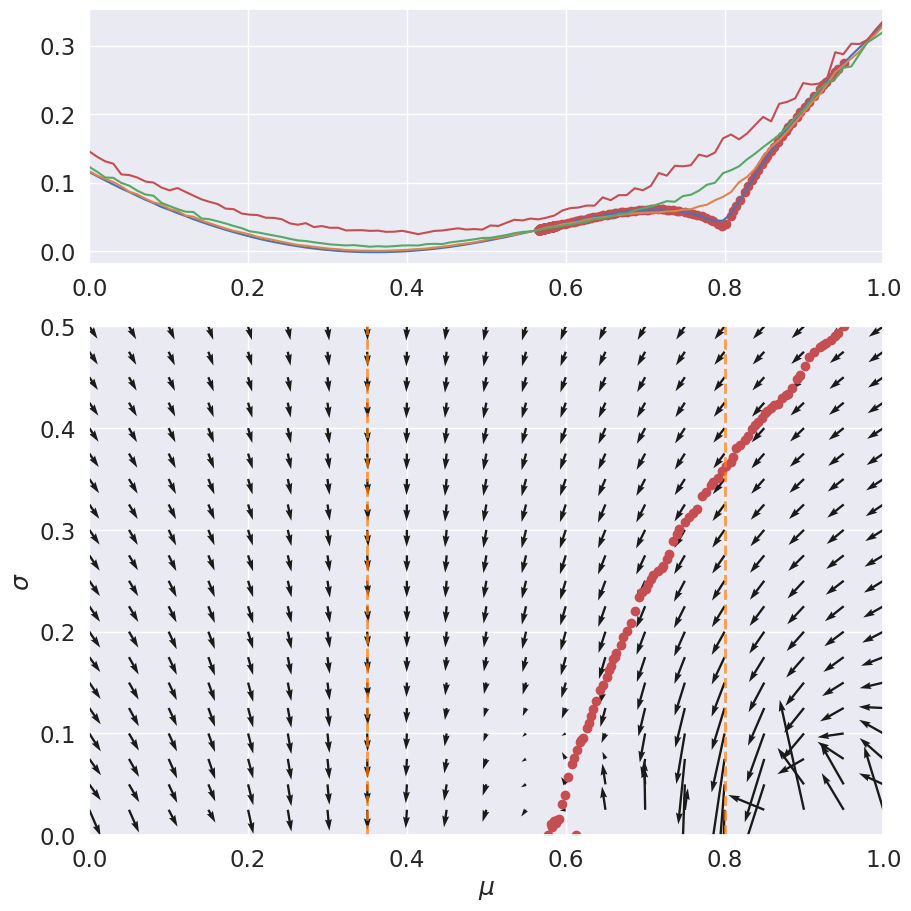

 91%|█████████ | 910/1000 [00:16<00:02, 32.10it/s]

 92%|█████████▏| 922/1000 [00:16<00:01, 41.04it/s]

 93%|█████████▎| 933/1000 [00:16<00:01, 50.25it/s]

 94%|█████████▍| 944/1000 [00:17<00:00, 59.76it/s]

 95%|█████████▌| 954/1000 [00:17<00:00, 58.06it/s]

 96%|█████████▋| 963/1000 [00:17<00:00, 63.82it/s]

 97%|█████████▋| 974/1000 [00:17<00:00, 73.01it/s]

 98%|█████████▊| 985/1000 [00:17<00:00, 81.15it/s]

100%|█████████▉| 996/1000 [00:17<00:00, 86.99it/s]

100%|██████████| 1000/1000 [00:17<00:00, 56.40it/s]

In [22]:
epochs = 1000
num_samples = 100
eps = 1e-7
hist = defaultdict(list)

for epoch in tqdm(range(epochs)):
    sigma.data.clamp_(eps)
    grad_mu, grad_sigma = estimage_variational_grad(
        fun=fun_from_lecture, 
        create_dist=create_normal_distr, 
        parameters=[mu, sigma], 
        num_samples=num_samples
    )
    hist["mu"].append(mu.item())
    hist["sigma"].append(sigma.item())
    
    hist["grad_mu"].append(grad_mu.item())
    hist["grad_sigma"].append(grad_sigma.item())

    hist["fun"].append(
        estimage_variational_bound(
            fun=fun_from_lecture, 
            create_dist=create_normal_distr, 
            parameters=[mu, sigma], 
            num_samples=100000
        ).item()
    )
    
    opt.zero_grad()
    # GOSH! We didn't backprop between `opt.zero_grad()` and `opt.step()`
    mu.grad = grad_mu.data
    sigma.grad = grad_sigma.data
    opt.step()
    sigma.data.clamp_(eps)
    
    if epoch % 100 == 0:
        clear_output(wait=True)
        fig = plt.figure(figsize=(9, 9), constrained_layout=True, dpi=100)
        gs = fig.add_gridspec(2, 1, height_ratios=[1, 2])

        ax1 = fig.add_subplot(gs[0, 0])
        for sigma_tmp in sigma_plots:
            plt.plot(mus, sigma_plots[sigma_tmp], label=r"$\sigma={:.4}$".format(sigma_tmp))
        plt.scatter(hist['mu'], fun_from_lecture(torch.tensor(hist['mu'])), c='r')

        fig.add_subplot(gs[1, 0], sharex=ax1)

        plt.vlines([0.35, 0.8], ymin=0, ymax=sigma_grid[-1], lw=2, linestyles='--', color=plt.cm.tab10(1), alpha=0.75)
        plt.quiver(mu_grid, sigma_grid, -dJ_dmu.T, -dJ_dsigma.T, angles='xy')
        plt.scatter(hist['mu'], hist['sigma'], c='r')

        plt.ylim([0, sigma_grid[-1]])
        plt.xlim([mu_grid[0], mu_grid[-1]])

        plt.xlabel('$\\mu$');
        plt.ylabel('$\\sigma$');
        plt.show()

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), dpi=100)
axes[0].plot(hist['mu'], label=r'$\mu$')
axes[0].plot(hist['sigma'], label=r'$\sigma$')
axes[0].set_yscale('log')
axes[0].legend()

axes[1].plot(hist['grad_mu'], label=r'$grad \mu$')
axes[1].plot(hist['grad_sigma'], label=r'$grad \sigma$')
axes[1].set_yscale('log')
axes[1].legend()
fig.tight_layout()

### If you observe something strange during optimization try to change parameter in `sigma.data.clamp_`

### Lesson: gradients are not stable

$$\nabla_{\mu} J(\mu, \sigma) = f(x) \frac{x - \mu}{\sigma^2} \propto \frac{1}{\sigma}$$

$$\nabla_{\sigma} J(\mu, \sigma) = f(x) \frac{(x - \mu)^2 - \sigma^2}{\sigma^2} \propto \frac{1}{\sigma}$$

So it is possible that gradients are going to oscillate.

![Gradient instability](https://raw.githubusercontent.com/SchattenGenie/pic-storage/master/gradient_instability.png)

# 2. Gumbel Softmax Trick




![](https://miro.medium.com/max/640/1*1vCjxSiR1DArqH208HcLcQ.png)

Many objects we want to learn are fundamentally discrete -- words, object classes, musical notes. We can think in this categories, but Neural Network is not able.

If we want neural network to be able to operate with objects and concepts, it should be able to be work with discrete variable.

#### Note: necessary but not sufficient condition

#### One of the ways to teach network discrete variables is Gumbel Softmax


![Pic](https://raw.githubusercontent.com/SchattenGenie/pic-storage/master/humbel_meme.jpg)

$$y_i = \frac{ \exp((\log \pi_i + G_i) / \tau) }{\sum\limits_j \exp((\log \pi_j + G_j) / \tau)},~~~G_i = - \log (-\log u_i),~~~u_i \sim U[0, 1],$$

#### To demonstrate this technique in practice, we will train classifier on the MNIST with the discrete layer.

## 2.1 Setting up all neccessery functions

In [0]:
def sample_gumbel(shape, eps=1e-20): 
    """
    shape: tuple of ints, i.e. (1, 2) or (54, 7, 3)
    
    Sample from Gumbel(0, 1)
    """
    # YOUR CODE HERE
    raise NotImplementedError()
    return sample

In [0]:
assert sample_gumbel((1, 2, 3)).shape == (1, 2, 3)
assert sample_gumbel((10, 100)).shape == (10, 100)
m = (-(-sample_gumbel((1000, 1000))).exp()).exp()
np_testing.assert_approx_equal(m.mean(), 0.5, significant=2)
assert (-(-sample_gumbel((1000, 1000))).exp()).exp().max() <= 1.
assert (-(-sample_gumbel((1000, 1000))).exp()).exp().min() >= 0.

In [0]:
def gumbel_softmax_sample(logits, temperature): 
    """
    logits: [batch_size, num_distributions]torch.Tensor that represents unnormalized log-probs 
             of the batch_size categorical distributions
    temperature: torch.Tensor scalar, temperature of the Gumbel SoftMax Distribution
    
    Draw a sample from the Gumbel-Softmax distribution
    """
    # YOUR CODE HERE
    raise NotImplementedError()
    return g

In [0]:
logits = torch.tensor([[1, 2, 8, 1, 2]]).float()
temperature = torch.tensor(1e10)
np_testing.assert_allclose(
    gumbel_softmax_sample(logits, temperature).numpy(), 
    np.array([[0.2000, 0.2000, 0.2000, 0.2000, 0.2000]]),
    rtol=1e-3,
    atol=1e-3
)


temperature = torch.tensor(1e-20)
np_testing.assert_allclose(
    gumbel_softmax_sample(logits, temperature).numpy(), 
    np.array([[0., 0., 1., 0., 0.]]),
    rtol=1e-3,
    atol=1e-3
)

temperature = torch.tensor(1.)
np_testing.assert_allclose(
    gumbel_softmax_sample(logits, temperature).sum().numpy(), 
    1.,
    rtol=1e-3,
    atol=1e-3
)

In [0]:
def gumbel_softmax(logits, temperature, hard=False):
    """
    Sample from the Gumbel-Softmax distribution and optionally discretize.
    
    logits: [batch_size, num_distributions] unnormalized log-probs
    temperature: non-negative scalar
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
    
    Returns:
    [batch_size, num_distributions] sample from the Gumbel-Softmax distribution.
    If hard=True, then the returned sample will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
    """
    # YOUR CODE HERE
    raise NotImplementedError()
    return y

In [0]:
logits = torch.tensor([[1, 2, 8, 1, 2]]).float()
temperature = torch.tensor(1e10)
np_testing.assert_allclose(
    gumbel_softmax(logits, temperature).numpy(), 
    np.array([[0.2000, 0.2000, 0.2000, 0.2000, 0.2000]]),
    rtol=1e-3,
    atol=1e-3
)


temperature = torch.tensor(1e-20)
np_testing.assert_allclose(
    gumbel_softmax(logits, temperature).numpy(), 
    np.array([[0., 0., 1., 0., 0.]]),
    rtol=1e-3,
    atol=1e-3
)

temperature = torch.tensor(1.)
np_testing.assert_allclose(
    gumbel_softmax(logits, temperature).sum().numpy(), 
    1.,
    rtol=1e-3,
    atol=1e-3
)


temperature = torch.tensor(1e10)
np_testing.assert_allclose(
    gumbel_softmax(logits, temperature, hard=True).numpy().max(), 
    1.,
    rtol=1e-3,
    atol=1e-3
)


temperature = torch.tensor(1e-20)
np_testing.assert_allclose(
    gumbel_softmax(logits, temperature).numpy(), 
    np.array([[0., 0., 1., 0., 0.]]),
    rtol=1e-3,
    atol=1e-3
)

temperature = torch.tensor(1.)
np_testing.assert_allclose(
    gumbel_softmax(logits, temperature).sum().numpy(), 
    1.,
    rtol=1e-3,
    atol=1e-3
)

logits = torch.tensor([[1, 2, 8, 1, 2]]).float().requires_grad_(True)
assert gumbel_softmax(logits, temperature).requires_grad == True

## N.B. Small lecture follow-up 

In the lecture I wrote:


During forward pass:

$\newcommand{\Argmax}{\mathop{{\rm Arg\,max}}}$
$$z = \textrm{one-hot}(\Argmax \{ y_i \}),$$

During backward pass:

$$\frac{dy}{d\pi} \rightarrow \frac{dz}{d \pi},~~~\tau \rightarrow 0$$


##### However, there is one thing to note.

In [0]:
logits = torch.tensor([[1, 2, 4, 1, 2]]).float().requires_grad_(True)

### With temperature, soft Gumbel Softmax Trick:

##### You can use soft version in networks and functions that are able to work with RELAXED discrete input variables

#### During forward pass:

In [0]:
temperature = torch.tensor(1.)
output = gumbel_softmax(logits, temperature, hard=False)

In [0]:
output

#### During backward pass:

In [0]:
autograd.grad(output.sin().sum(), logits)

### With temperature, hard Gumbel Softmax Trick:


##### You should use hard version in functions that require discrete function as an input ONLY discrete input variable

#### During forward pass:

In [0]:
temperature = torch.tensor(1.)
output = gumbel_softmax(logits, temperature, hard=True)

In [0]:
output

#### During backward pass:

In [0]:
autograd.grad(output.sin().sum(), logits)

## 2.2 Now we are all set to train a small classifier

In [0]:
class GumbelLayer(nn.Module):
    def __init__(self, in_features, num_distributions=20, num_classes=10, temperature=5., hard=False, flatten=True):
        super(GumbelLayer, self).__init__()
        self.linear = nn.Linear(in_features, num_distributions * num_classes)
        self.num_classes = num_classes
        self.num_distributions = num_distributions
        self.temperature = temperature
        self.hard = hard
        self.flatten = flatten
        print("Output size of GumbelLayer is equal to: {}".format(num_distributions * num_classes))

    def forward(self, input):
        logits_y = self.linear(input).view(-1, self.num_classes)
        y = gumbel_softmax(logits_y, self.temperature, hard=self.hard).view(-1, self.num_distributions * self.num_classes)
        if not self.flatten:
            y = y.view(-1, self.num_distributions, self.num_classes)
        return y

    def set_hard(self, hard):
        self.hard = hard
        
    def set_temperature(self, temperature):
        self.temperature = temperature
    
    def set_flatten(self, flatten):
        self.flatten = flatten

In [0]:
def get_free_gpu():
    from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlDeviceGetCount
    nvmlInit()

    return np.argmax([
        nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(i)).free
        for i in range(nvmlDeviceGetCount())
    ])


if torch.cuda.is_available():
    cuda_id = get_free_gpu()
    device = 'cuda:%d' % (get_free_gpu(), )
    print('Selected %s' % (device, ))
else:
    device = 'cpu'
    print('WARNING: using cpu!')

### please, don't remove the following line
x = torch.tensor([1], dtype=torch.float32).to(device)

Building our tiny nice classifier

In [0]:
classifier = torch.nn.Sequential(
    nn.Linear(784, 512),
    nn.Tanh(),
    GumbelLayer(512, num_distributions=1, num_classes=10, temperature=5., hard=False),
    nn.Tanh(),
    nn.Linear(10, 64),
    nn.Tanh(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=-1)
).to(device)

opt = torch.optim.Adam(params=classifier.parameters(), lr=1e-3)

In [0]:
from torchvision import datasets, transforms
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

# Or was it ../../data?..
train_dataset = datasets.MNIST('../../../share', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)

test_dataset = datasets.MNIST('../../../share', train=True, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

In [0]:
temperature = 1.
hist = defaultdict(list)

for epoch in tqdm(range(3)):
    print("temperature={}".format(temperature))
    # temperature annealing
    temperature = 1. / np.log(2. + epoch)
    classifier[2].set_temperature(temperature)
    
    for X, target in tqdm(train_loader):
        X = X.view(-1, 784).to(device)
        target = target.to(device)
        preds = classifier(X)
        
        loss = nn.NLLLoss()(preds, target)
    
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    loss_test = 0.
    accuracy_test = 0.
    for X, target in tqdm(test_loader):
        X = X.view(-1, 784).to(device)
        target = target.to(device)
        preds = classifier(X)
        accuracy_test += (preds.argmax(dim=1) == target).float().mean().item() / len(test_loader)
        loss_test += nn.NLLLoss()(preds, target).item() / len(test_loader)
    
    hist['accuracy'].append(accuracy_test)
    hist['loss'].append(loss_test)
    clear_output(wait=True)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
    axes[0].plot(np.arange(1 + epoch), hist['loss'], label="Loss")
    axes[0].legend()
    axes[1].plot(np.arange(1 + epoch), hist['accuracy'], label="Accuracy")
    axes[1].legend()
    fig.tight_layout()
    plt.show()

### Let's chop the head of the classifier!



In [0]:
discrete_net = nn.Sequential(*list(classifier.children())[:-5])

In [0]:
discrete_net

In [0]:
discrete_net = discrete_net.cpu()

Try to play with `hard` parameter and `temperature` of the 

In [0]:
discrete_net[-1].set_hard(False)
discrete_net[-1].set_flatten(False)
discrete_net[-1].set_temperature(0.1)

In [0]:
X_discrete = discrete_net(test_dataset.data.view(-1, 784).float())

In [0]:
targets = test_dataset.targets

In [0]:
X_discrete[0]

### Even without annealing of $\tau$ to zero Gumbel predicts almost discrete variables

In [0]:
plt.figure(figsize=(12, 8))
plt.imshow(X_discrete[0].detach().cpu().numpy())
plt.title('Number={}'.format(targets[0]))
plt.colorbar();

In [0]:
plt.figure(figsize=(12, 8))
plt.imshow(X_discrete[1].detach().cpu().numpy())
plt.title('Number={}'.format(targets[1]))
plt.colorbar();

In [0]:
plt.figure(figsize=(12, 8))
plt.imshow(X_discrete[11].detach().cpu().numpy())
plt.title('Number={}'.format(targets[11]))
plt.colorbar();

### Let's calculate some statistics

In [0]:
stats = defaultdict(list)
for i in range(len(X_discrete)):
    stats[targets[i].item()].append(X_discrete[i].detach().cpu().numpy())

In [0]:
stats.keys()

In [0]:
mean_discrete_variable = []
std_discrete_variable = []
for num in range(10):
    mean_discrete_variable.append(np.concatenate(stats[num]).mean(axis=0))
    std_discrete_variable.append(np.concatenate(stats[num]).std(axis=0) / np.sqrt(len(stats[num])))
mean_discrete_variable = np.array(mean_discrete_variable)
std_discrete_variable = np.array(std_discrete_variable)

In [0]:
import pandas as pd
np.set_printoptions(precision=2)

In [0]:
df = pd.DataFrame(mean_discrete_variable)
corr = df.corr()

mask = np.tril(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
plt.figure(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

### Let's plot for each number distribution among discrete variables

In [0]:
fig, ax = plt.subplots(5, 2, sharex=True, figsize=(20, 22))
for i in range(10):
    ax[i % 5][i // 5].bar(np.arange(mean_discrete_variable.shape[1]), mean_discrete_variable[i], yerr=std_discrete_variable[i], align='center', alpha=0.5, ecolor='black', capsize=10)
    ax[i % 5][i // 5].set_title("Number={}".format(i))
plt.show()